In [12]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(1)
np.random.seed(1)
torch.set_printoptions(precision=3)

In [13]:
# Model
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input   = torch.nn.Linear(4, 32)
    self.output  = torch.nn.Linear(32, 1)

  def forward(self, x):
    z = torch.selu(self.input(x))
    z = self.output(z)
    return z

In [14]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x_data)
    
    pred_Y = torch.relu(pred_Y) - torch.relu(pred_Y - 100)
    
    # R^2
    SSR = torch.sum(torch.square(pred_Y - testset.y_data))
    SST = torch.sum(torch.square(pred_Y - torch.mean(testset.y_data)))
    r2 = 1 - SSR/SST
    
    # RMSE
    rmse = torch.sqrt(torch.mean(torch.square(pred_Y - testset.y_data)))
    return r2, rmse

In [15]:
# Create network
device = torch.device("cpu")
net = Net().to(device)

In [16]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file, start=None, end=None):
    df = pd.read_csv(src_file)
    hvc_k2 = np.array(df['htg_valve_command']).reshape(-1,1)[start+3: end+3]
    hvp_k  = np.array(df['htg_valve_position']).reshape(-1,1)[start: end]
    hvp_k1 = np.array(df['htg_valve_position']).reshape(-1,1)[start+1: end+1]
    hvp_k2 = np.array(df['htg_valve_position']).reshape(-1,1)[start+2: end+2]
    
    tmp_x = np.concatenate((hvc_k2, hvp_k, hvp_k1, hvp_k2), axis=1)
    tmp_y = np.array(df['htg_valve_position']).reshape(-1,1)[start+3: end+3]
    
    self.x_data = torch.tensor(tmp_x, dtype=torch.float32)
    self.y_data = torch.tensor(tmp_y, dtype=torch.float32)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    inp  = self.x_data[idx]
    outp = self.y_data[idx]
    sample = {'inp':inp, 'outp':outp}
    return sample

# Create Dataset and DataLoader objects
src_file = 'C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv'
n_train  = 64
train_ds = Data(src_file, start=0, end=n_train)
test_ds  = Data(src_file, start=n_train, end=1600)

In [17]:
# train model
max_epochs = 5238
loss_func  = torch.nn.MSELoss()
optimizer  = torch.optim.Adam(net.parameters(), lr=0.001)

train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
R2 = np.array([])
for epoch in range(0, max_epochs+1):
    net.train()
    loss  = 0
    count = 0
    for (_, batch) in enumerate(train_ldr):
        X   = batch['inp']
        Y   = batch['outp']

        optimizer.zero_grad()
        output = net(X)                    # compute the output of the Network
        loss_val = loss_func(output, Y)    # loss function
        loss += loss_val.item()            # accumulate
        loss_val.backward()                # gradients
        optimizer.step()                   # update paramters
        count += 1

    net.eval()
    R2 = np.append(R2, eval(net, test_ds)[0].item())
    if(epoch%500==0):
        print("epoch = %5d \t loss = %8.3f \t RMSE = %7.3f \t R2 = %8.5f" %
              (epoch, loss/count, eval(net, test_ds)[1].item(), eval(net, test_ds)[0].item()))

epoch =     0 	 loss = 3484.925 	 RMSE =  57.646 	 R2 = -0.75836
epoch =   500 	 loss =   22.079 	 RMSE =   3.693 	 R2 =  0.99020
epoch =  1000 	 loss =   21.619 	 RMSE =   3.637 	 R2 =  0.99054
epoch =  1500 	 loss =   21.561 	 RMSE =   3.628 	 R2 =  0.99059
epoch =  2000 	 loss =   21.509 	 RMSE =   3.621 	 R2 =  0.99063
epoch =  2500 	 loss =   21.468 	 RMSE =   3.617 	 R2 =  0.99065
epoch =  3000 	 loss =   21.410 	 RMSE =   3.614 	 R2 =  0.99067
epoch =  3500 	 loss =   21.309 	 RMSE =   3.607 	 R2 =  0.99070
epoch =  4000 	 loss =   21.214 	 RMSE =   3.604 	 R2 =  0.99073
epoch =  4500 	 loss =   21.099 	 RMSE =   3.601 	 R2 =  0.99074
epoch =  5000 	 loss =   20.935 	 RMSE =   3.599 	 R2 =  0.99075


In [18]:
def plot(dataset, size):
    with torch.no_grad():
        pred_Y = net(dataset.x_data)
        
    pred_Y = torch.relu(pred_Y) - torch.relu(pred_Y - 100)
    plt.figure(figsize=size)
    plt.plot(dataset.y_data, 'b-', label=r'$m_{sa}$ measured')
    plt.plot(pred_Y,         'r-', label=r'$m_{sa}$ predicted')
    plt.legend()
    plt.show()

RMSE: 4.5639238357543945
R2: 0.9811998605728149


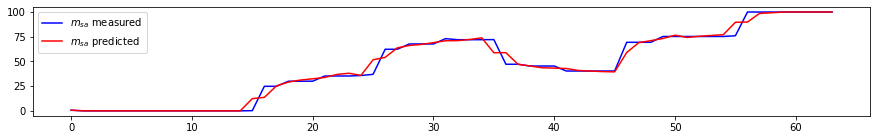

In [19]:
net.eval()
print("RMSE:", eval(net, train_ds)[1].item())
print("R2:",   eval(net, train_ds)[0].item())
plot(train_ds, (15, 2))

RMSE: 3.599069356918335
R2: 0.9907616972923279


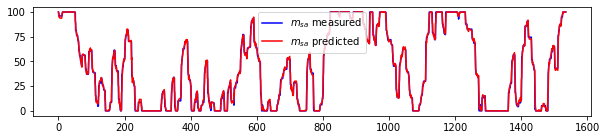

In [20]:
net.eval()
print("RMSE:", eval(net, test_ds)[1].item())
print("R2:",   eval(net, test_ds)[0].item())
plot(test_ds, (10, 2))

In [21]:
print(np.argmax(R2))
print(np.max(R2))

5238
0.9907616972923279


In [22]:
PATH = 'C:/Users/tln229/Downloads/Python/Building/0. Saved models/qrh.pt'
torch.save(net, PATH)